# Table extraction tutorial

This worked reasonably well. some minor bits to tune like the image threshold type, and this won't work for borderless tables.

However, it does give a good overview of how once we have the contours associated to the table, we can extract the contents using pytesseract.

https://towardsdatascience.com/a-table-detection-cell-recognition-and-text-extraction-algorithm-to-convert-tables-to-excel-files-902edcf289ec


### Extension to borderless

One way we could extend to borderless is to take this idea 

    Try vertical profile, which is count of text (black) pixels with the same X coordinate in certain (Y0, Y1) range (table vertical span). Zero or near zero regions will indicate table column borders. Here is a hand drawn, approximate profile for your example:

i.e. use regions with lots of whitespace as a boundary. Since our table has rows, we should probs use some method that uses a threshold below the mean non-whitespace pixels

In [1]:
!pip install matplotlib

In [112]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import csv

try:
    from PIL import Image
except ImportError:
    import Image

import pytesseract

%matplotlib inline
plt.rc('figure', figsize=(30, 20.0))

DATA_ROOT = 'data/tables/'

## Loading the image

First let us load hte image, and convert it the appropriate format:
- binary image
- invert to white on black lines and font

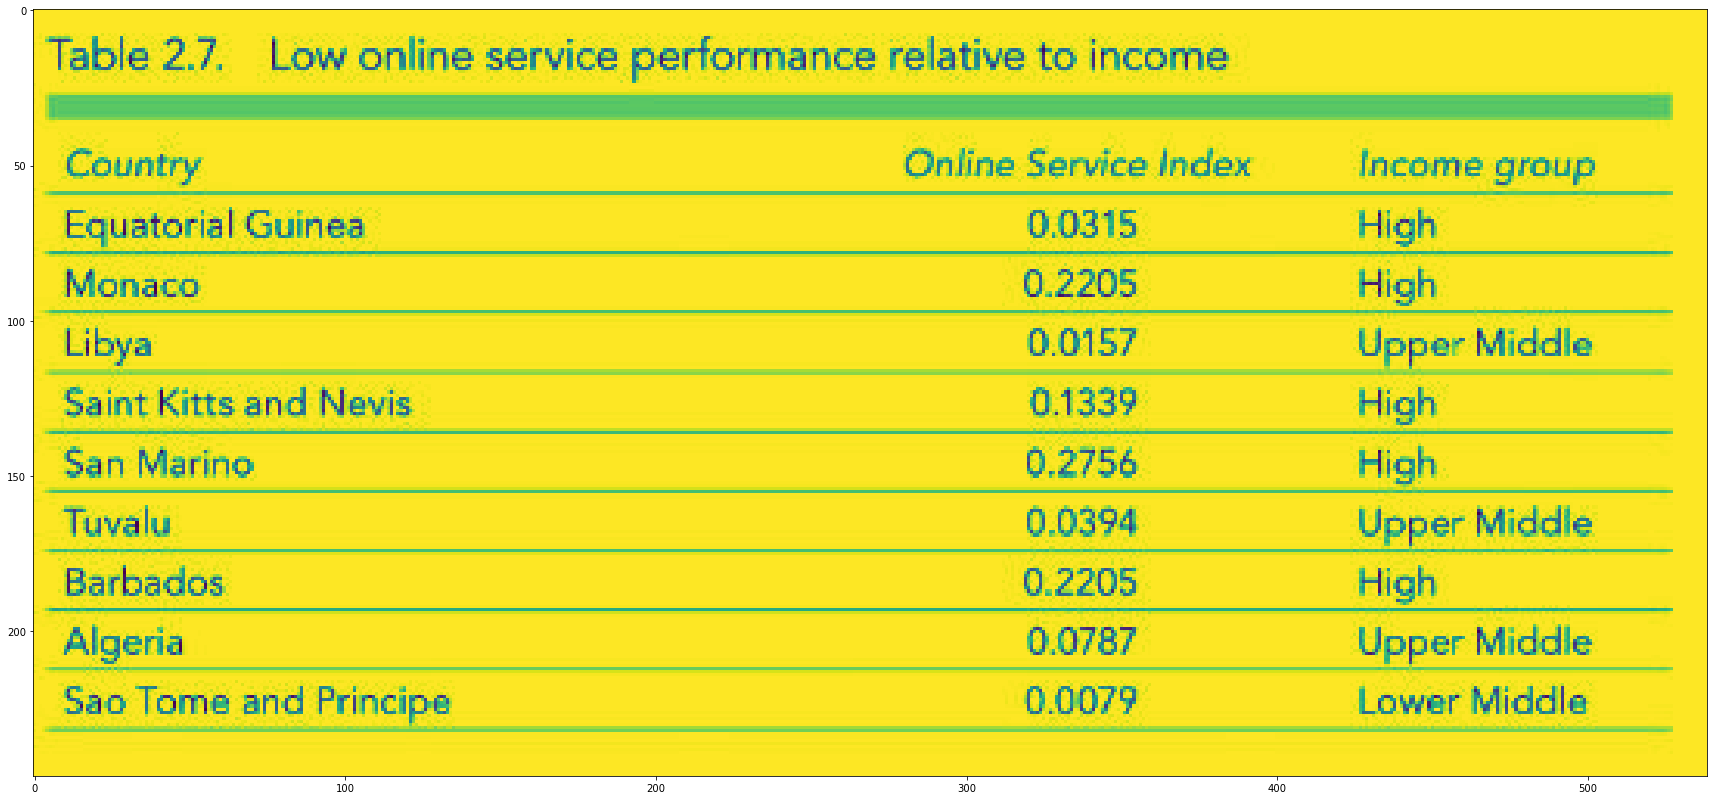

In [355]:
PATH = f'{DATA_ROOT}/table2.jpg'

img = cv2.imread(PATH, cv2.IMREAD_GRAYSCALE) # cv2.IMREAD_GRAYSCALE for b&w image
plotting = plt.imshow(img)

In [362]:
# threshold to binary image 
thresh, img_bin = cv2.threshold(img, thresh=128, maxval=255, type=cv2.THRESH_BINARY | cv2.THRESH_OTSU) # cv2.ADAPTIVE_THRESH_MEAN_C
print(thresh) 

203.0


In [363]:
BINARY_FPATH = f'{DATA_ROOT}/bin_cTDaR_t10120.jpg'

# invert the image
img_bin = 255 - img_bin
cv2.imwrite(BINARY_FPATH, img_bin)

True

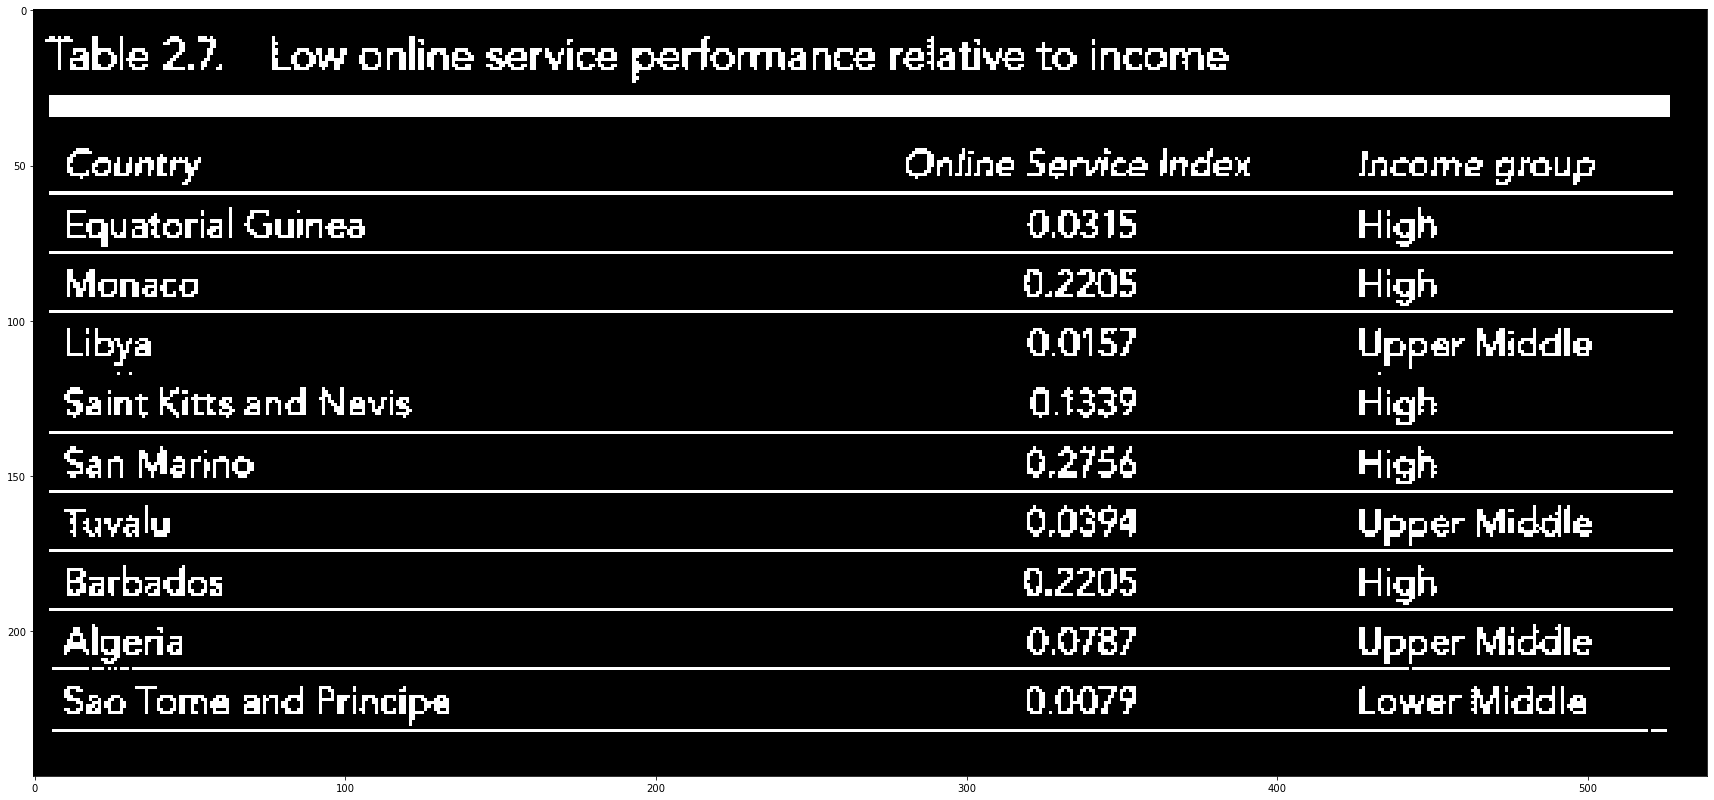

In [364]:
# plotting the image to see the output.
plotting = plt.imshow(img_bin, cmap='gray')

TODO: remove, but the below shows the different threshold functions on the same image.

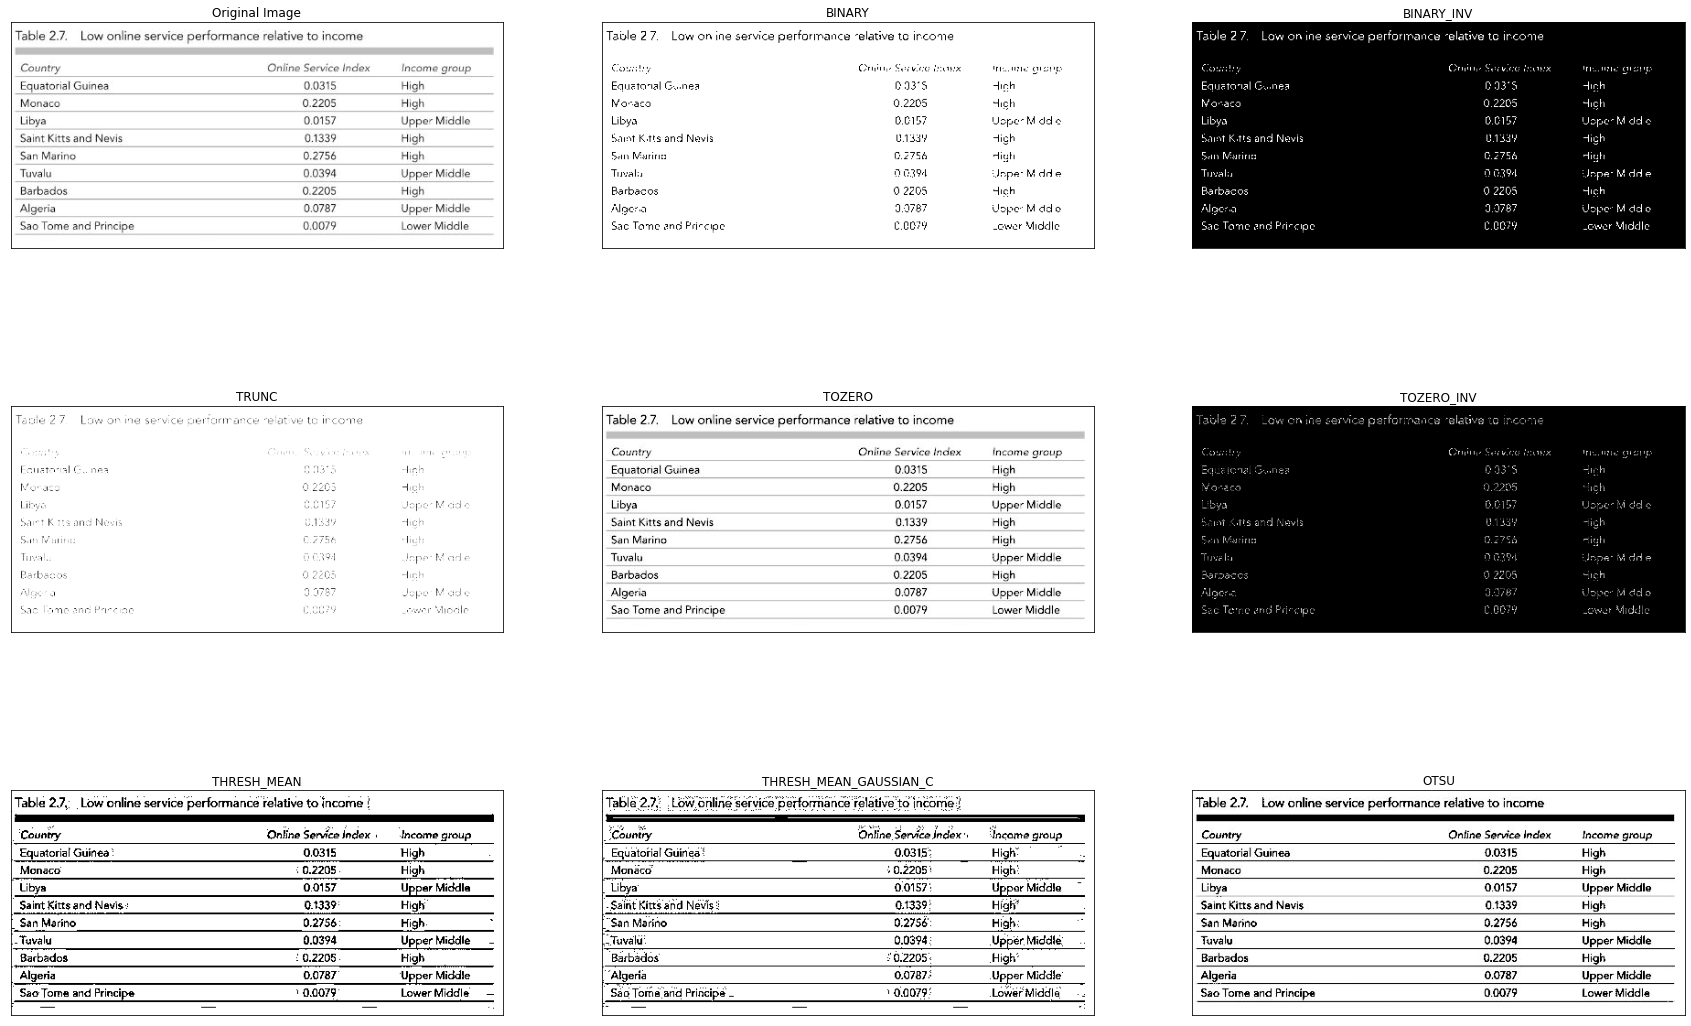

In [365]:
ret,thresh1 = cv2.threshold(img,127,255,cv2.THRESH_BINARY)
ret,thresh2 = cv2.threshold(img,127,255,cv2.THRESH_BINARY_INV)
ret,thresh3 = cv2.threshold(img,127,255,cv2.THRESH_TRUNC)
ret,thresh4 = cv2.threshold(img,127,255,cv2.THRESH_TOZERO)
ret,thresh5 = cv2.threshold(img,127,255,cv2.THRESH_TOZERO_INV)
thresh6 = cv2.adaptiveThreshold(img,255,cv2.ADAPTIVE_THRESH_MEAN_C,cv2.THRESH_BINARY,11,2)
thresh7 = cv2.adaptiveThreshold(img,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY,11,2)
_, thresh8 = cv2.threshold(img,0,255,cv2.THRESH_TOZERO+cv2.THRESH_OTSU)


titles = ['Original Image','BINARY','BINARY_INV','TRUNC','TOZERO','TOZERO_INV', 'THRESH_MEAN', 'THRESH_MEAN_GAUSSIAN_C', 
          'OTSU']
images = [img, thresh1, thresh2, thresh3, thresh4, thresh5, thresh6, thresh7, thresh8]

for i in range(len(images)):
    plt.subplot(3,3,i+1),plt.imshow(images[i],'gray')
    plt.title(titles[i])
    plt.xticks([]),plt.yticks([])

## Define table lines

Next, let us define the kernel for identifying vertical and horizontal lines within the table(s).

In [366]:
# Length(width) of kernel as 100th of total width
kernel_len = img.shape[1] // 100

# Defining a vertical kernel to detect all vertical lines of image 
ver_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, kernel_len))

# Defining a horizontal kernel to detect all horizontal lines of image
hor_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (kernel_len, 1))

# A kernel of 2x2
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 2))

 Detection of vertical lines

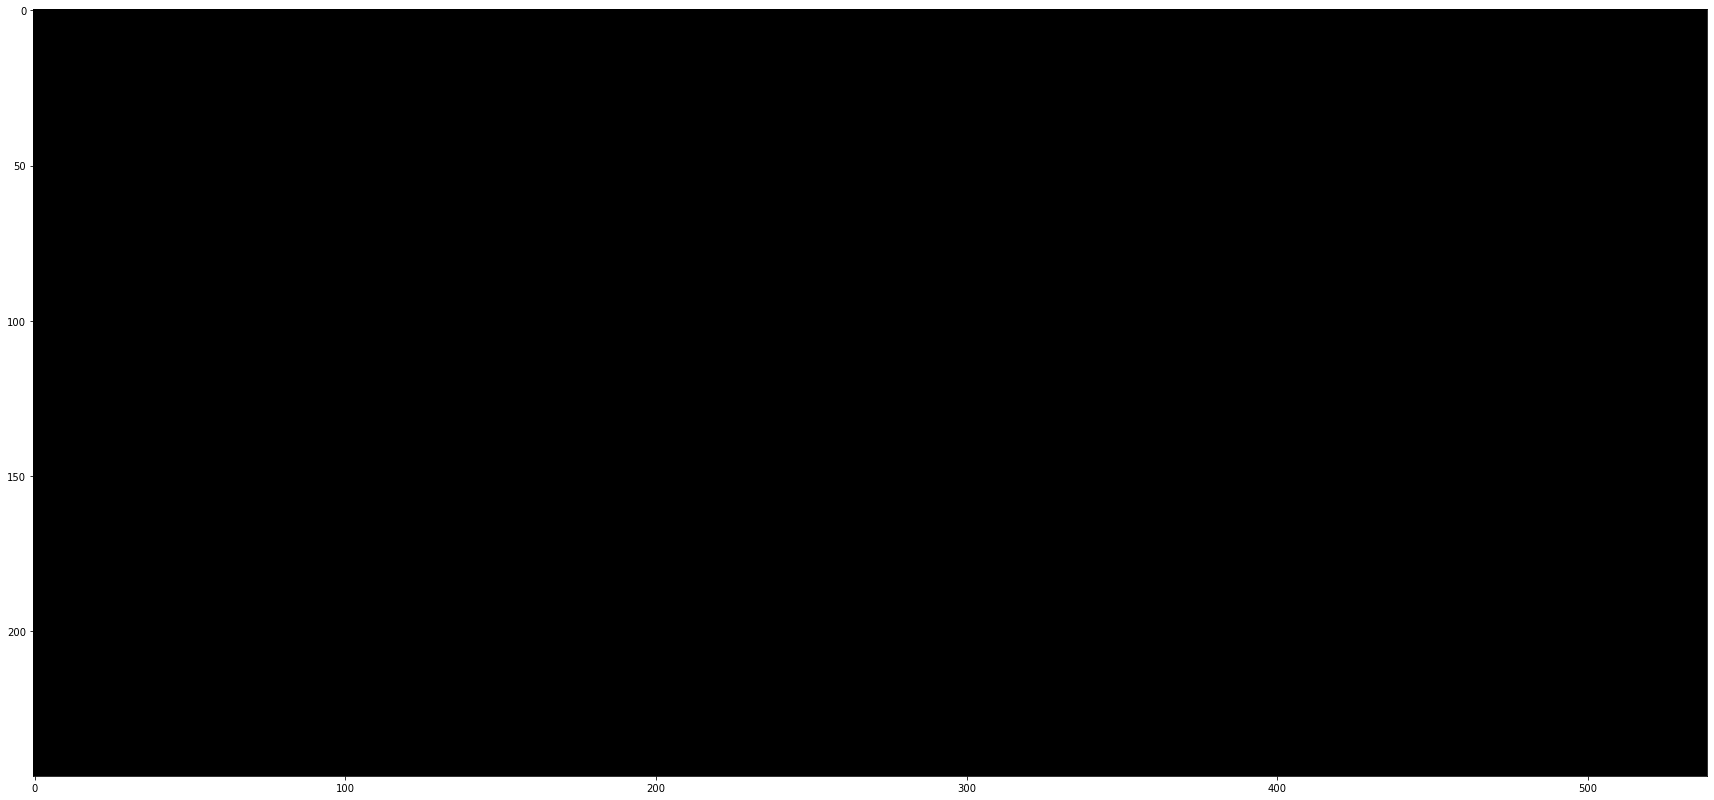

In [367]:
#Use vertical kernel to detect and save the vertical lines in a jpg
ver_image = cv2.erode(img_bin, ver_kernel, iterations=3)
vertical_lines = cv2.dilate(ver_image, ver_kernel, iterations=3)
cv2.imwrite(f'{DATA_ROOT}/vertical.jpg', vertical_lines)

#Plot the generated image
plotting = plt.imshow(ver_image, cmap='gray')

Detection of horizontal lines

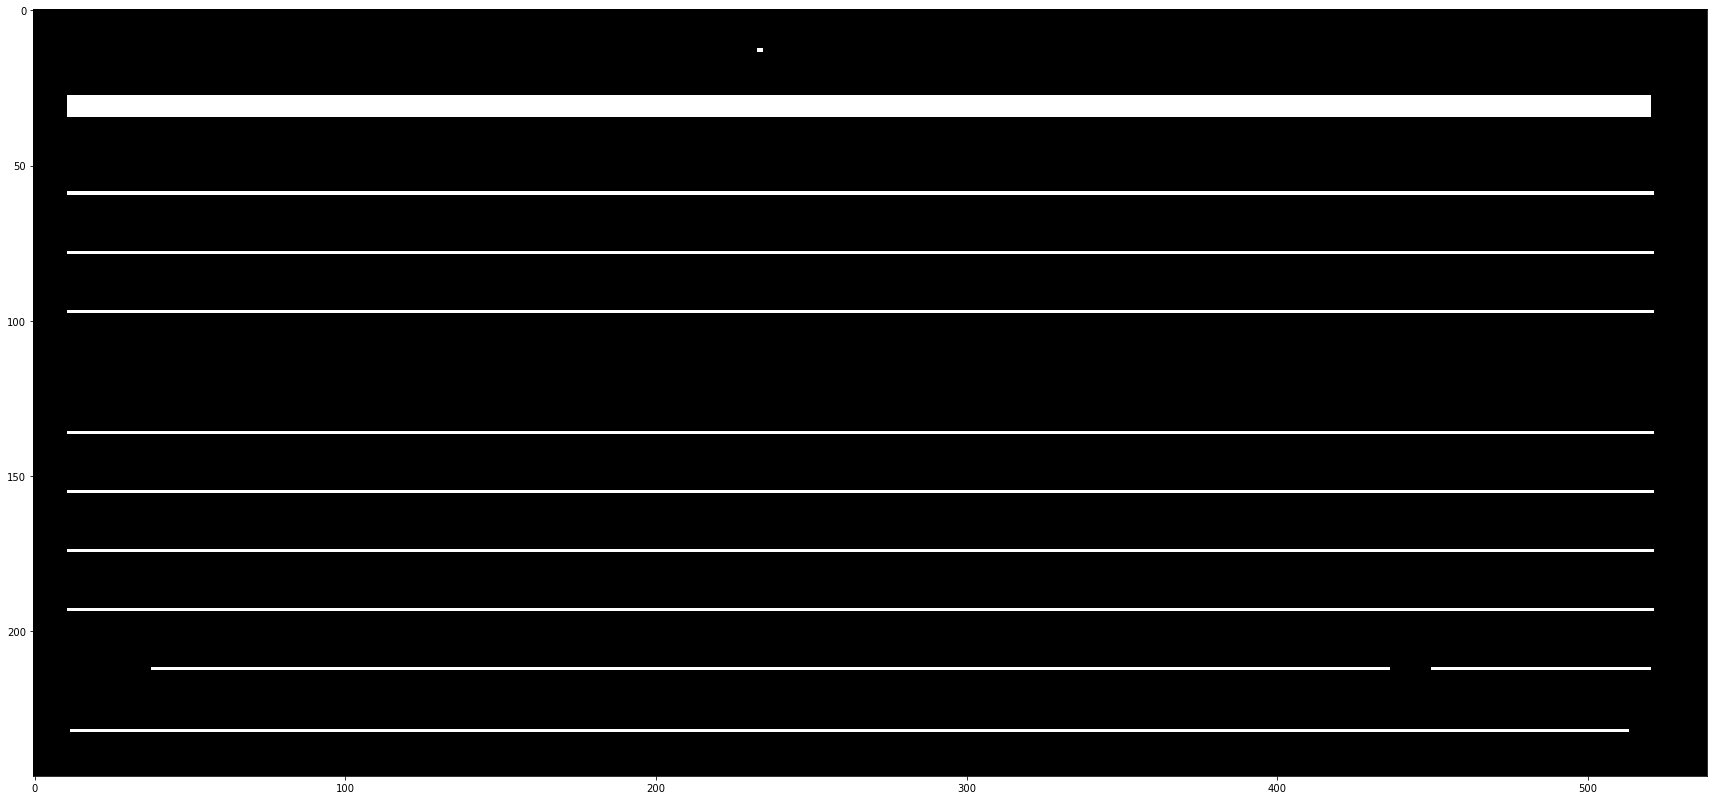

In [368]:
#Use horizontal kernel to detect and save the horizontal lines in a jpg
hor_image = cv2.erode(img_bin, hor_kernel, iterations=3)
horizontal_lines = cv2.dilate(hor_image, hor_kernel, iterations=3)
cv2.imwrite(f'{DATA_ROOT}/horizontal.jpg', horizontal_lines)

#Plot the generated image
plotting = plt.imshow(hor_image, cmap='gray')

Let us combine both into a third image, by weighting both with 0.5 the goal is to identify the cells

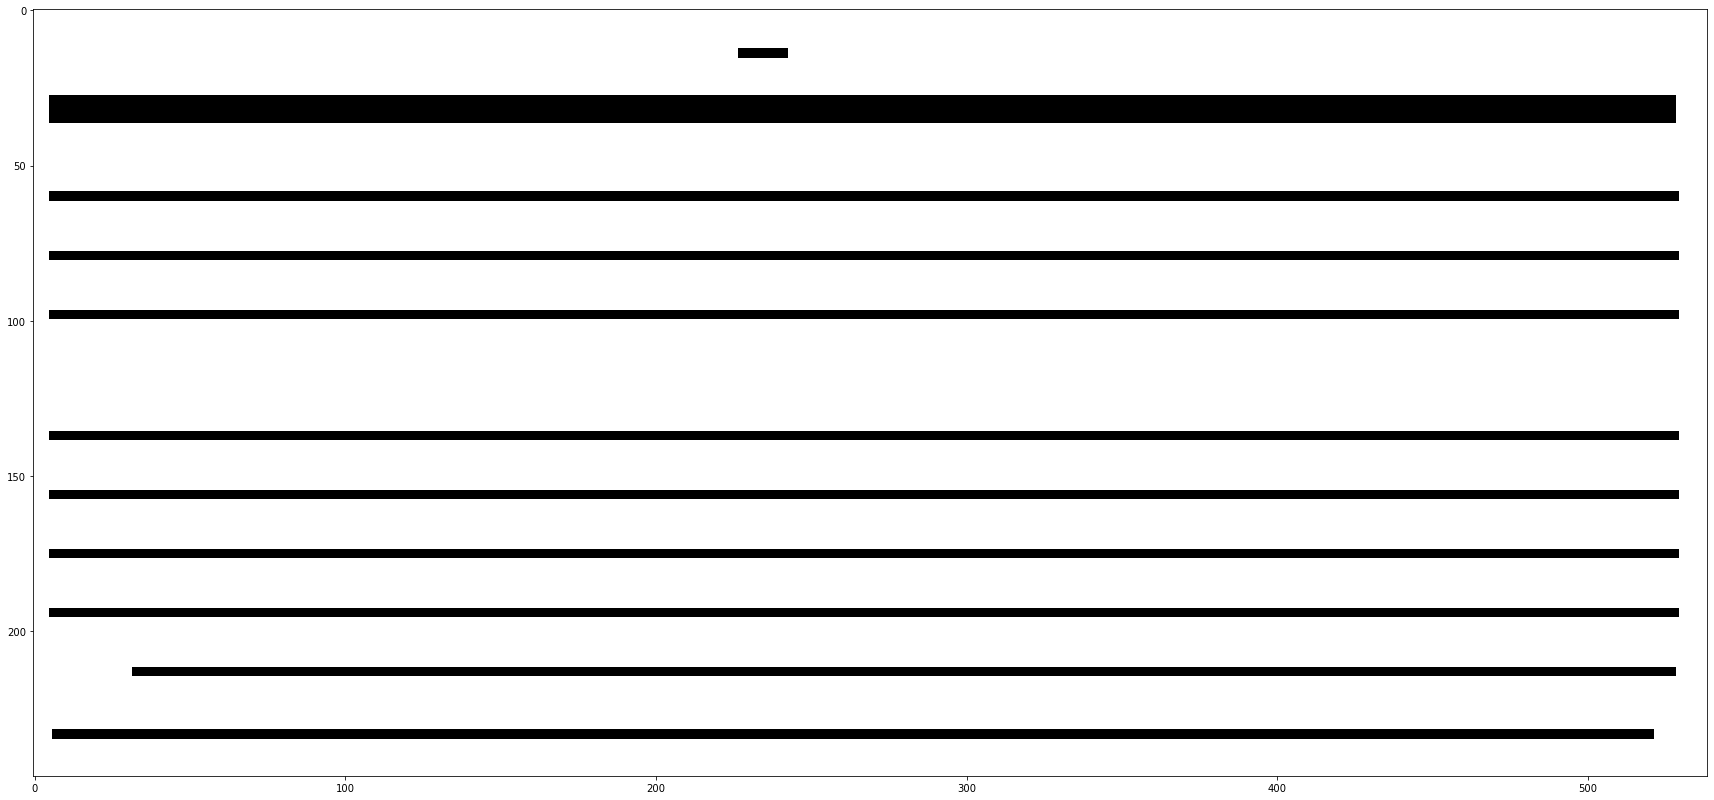

In [369]:
# Combine horizontal and vertical lines in a new third image, with both having same weight.
img_vh = cv2.addWeighted(vertical_lines, 0.5, horizontal_lines, 0.5, 0.0)

#Eroding and thesholding the image
img_vh = cv2.erode(~img_vh, kernel, iterations=2) # what does the tilda do here?
thresh, img_vh = cv2.threshold(img_vh, 128, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
cv2.imwrite(f'{DATA_ROOT}/img_vh.jpg', img_vh)

plotting = plt.imshow(img_vh, cmap='gray')

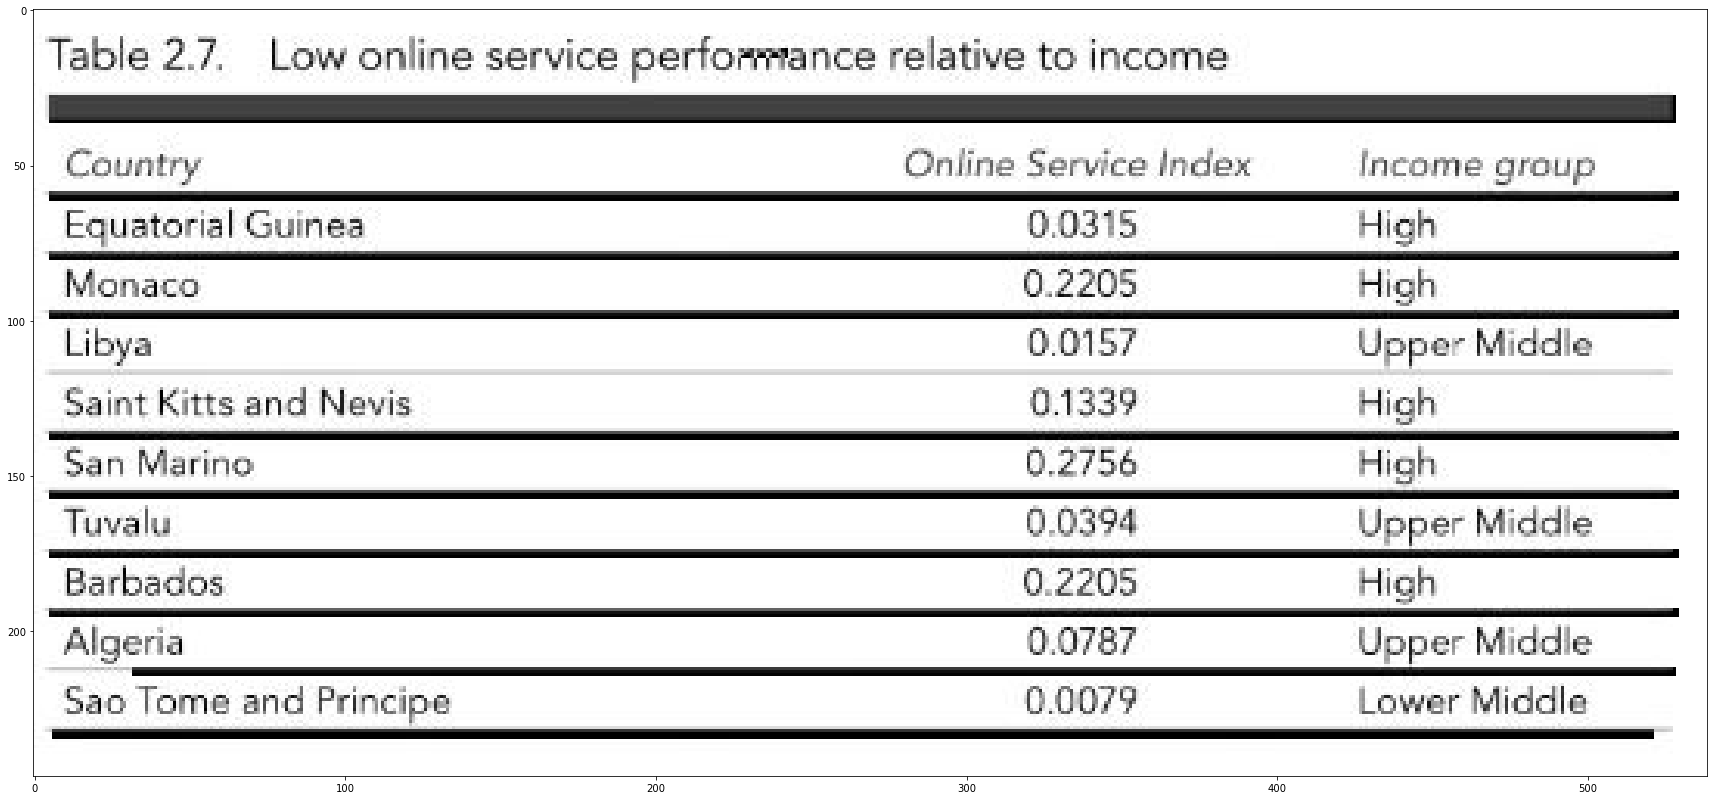

In [370]:
# what are the below bit ops doing? i'm assuming these are re-inverting the image again for boundaries?
bitxor = cv2.bitwise_xor(img, img_vh)
bitnot = cv2.bitwise_not(bitxor)

#Plotting the generated image. shows how the position of the lines is good I guess?
plt.figure(figsize=(30,30))
plotting = plt.imshow(bitnot, cmap='gray')

## Contour detection
Now we have the table structure, we can detect the contours. This will help give us the coordinates of each box.

This function will help us ID the contours (this may be replaceable by other approaches such as CascadeTabNet.

Sort fn lifted from here https://www.pyimagesearch.com/2015/04/20/sorting-contours-using-python-and-opencv/

NOTE: not convinced the below is doing what we want it to do in that it is not appearing to wrap the cells, more it is wrapping the vertical/horizontal lines?

In [371]:
# Detect contours for following box detection
contours, hierarchy = cv2.findContours(img_vh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

In [372]:
def sort_top_to_bottom(cnts, i, reverse):
    # construct the list of bounding boxes and sort them from top to bottom
    bounding_boxes = [cv2.boundingRect(c) for c in cnts]
    cnts, bounding_boxes = zip(*sorted(zip(cnts, bounding_boxes), key=lambda b:b[1][i], reverse=reverse))
    return cnts, bounding_boxes

def sort_contours(cnts, method="left-to-right"):
    # initialize the reverse flag and sort index
    reverse = False
    i = 0
    # handle if we need to sort in reverse
    if method == "right-to-left" or method == "bottom-to-top":
        reverse = True
    
    # handle if we are sorting against the y-coordinate rather than
    # the x-coordinate of the bounding box
    if method == "top-to-bottom" or method == "bottom-to-top":
        i = 1
    
    # construct the list of bounding boxes and sort them from top to bottom
    cnts, bounding_boxes = sort_top_to_bottom(cnts, i, reverse)
    
    # return the list of sorted contours and bounding boxes
    return cnts, bounding_boxes

In [373]:
# Sort all the contours by top to bottom.
contours, bounding_boxes = sort_contours(contours, method="top-to-bottom")

Next, let us retrieve the cell positions

In [374]:
#Creating a list of heights for all detected boxes
heights = [bounding_boxes[i][3] for i in range(len(bounding_boxes))]

#Get mean of heights
mean = np.mean(heights)
print(f'mean height: {mean}')

mean height: 25.666666666666668


Next, let us retrieve the position, width and heigh of each contour and store it in the box list. tthen let us draw rectangles around all of our boxes and plot the image.

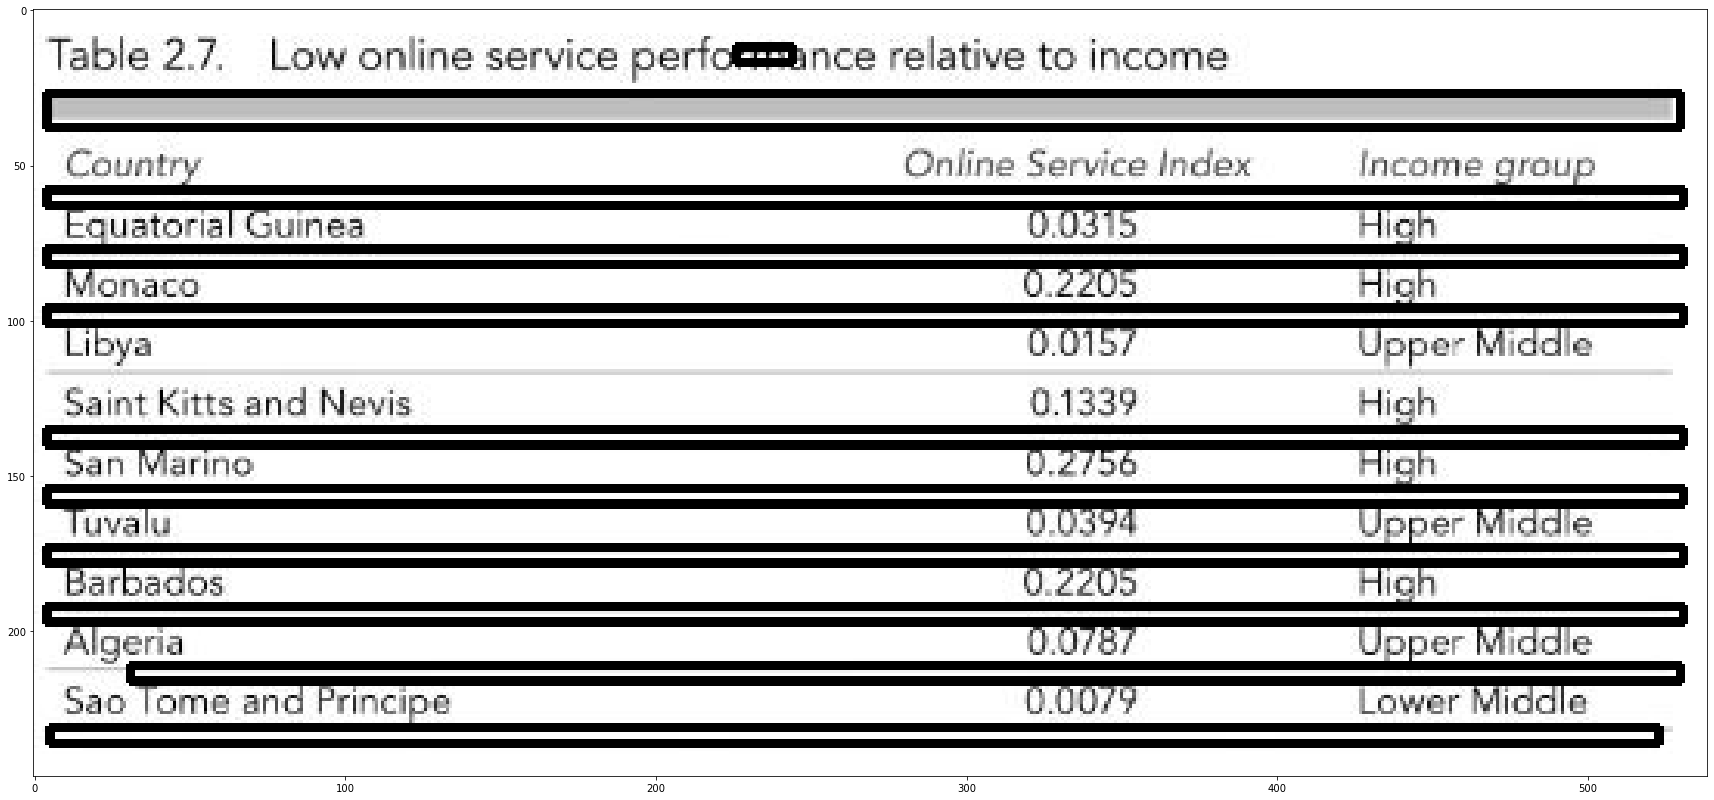

In [375]:
#Create list box to store all boxes in  
box = []
# Get position (x,y), width and height for every contour and show the contour on image
for c in contours:
    x, y, w, h = cv2.boundingRect(c)
    if (w < 1000 and h < 150): # optional for very wide or tall rows
        image = cv2.rectangle(img, (x, y),(x+w, y+h), (0, 255, 0), 2)
        box.append([x, y, w, h])
plt.figure(figsize=(30, 30))
plotting = plt.imshow(image, cmap='gray')

## Cell locations
Next, since we have each cell location, height and width we need to get the location within the table.

As long as a box does not differ more than its own (height + mean/2) the box is in the same row. There is a strong assumption here that there is a low std for the heights

In [376]:
row, column = [], []
j = 0

#Sorting the boxes to their respective row and column
for i in range(len(box)):
    if(i==0):
        column.append(box[i])
        previous = box[i]
    else:
        if(box[i][1] <= previous[1] + mean/2):
            column.append(box[i])
            previous = box[i]
            if (i == len(box) - 1):
                row.append(column)
        else:
            row.append(column)
            column = []
            previous = box[i]
            column.append(box[i])
            
print(column)
print(row)

[[5, 231, 518, 5]]
[[[226, 12, 18, 5]], [[4, 27, 526, 11]], [[4, 58, 527, 5]], [[4, 77, 527, 5]], [[4, 96, 527, 5]], [[4, 135, 527, 5]], [[4, 154, 527, 5]], [[4, 173, 527, 5]], [[4, 192, 527, 5]], [[31, 211, 499, 5]]]


We now calculate the max number of columns so we understand the shape of the final output (in this instance a dataframe)

In [377]:
col_lens = [len(r) for r in row]
max_idx = np.argmax(col_lens)
countcol = col_lens[max_idx]
print(countcol, '|', max_idx)

1 | 0


After having the maximum number of cells we store the midpoint of each column in a list, create an array and sort the values.

In [378]:
#Retrieving the center of each column
center = [int(row[max_idx][j][0] + row[max_idx][j][2] / 2) for j in range(len(row[max_idx])) if row[0]]

center = np.array(center)
center.sort()
center

array([235])

At this point, we have all boxes and their values, but as you might see in the output of your row list the values are not always sorted in the right order. That’s what we do next regarding the distance to the columns center. The proper sequence we store in the list finalboxes.

In [379]:
#Regarding the distance to the columns center, the boxes are arranged in respective order
finalboxes = []
for i in range(len(row)):
    lis=[]
    for k in range(countcol):
        lis.append([])
    for j in range(len(row[i])):
        diff = abs(center-(row[i][j][0]+row[i][j][2]/4))
        minimum = min(diff)
        indexing = list(diff).index(minimum)
        lis[indexing].append(row[i][j])
    finalboxes.append(lis)

## Extract the values
In the next step we make use of our list finalboxes. We take every image-based box, prepare it for Optical Character Recognition by dilating and eroding it and let pytesseract recognize the containing strings. The loop runs over every cell and stores the value in the outer list.

In [380]:
#from every single image-based cell/box the strings are extracted via pytesseract and stored in a list
outer=[]
for i in range(len(finalboxes)):
    for j in range(len(finalboxes[i])):
        inner = ''
        if(len(finalboxes[i][j])==0):
            outer.append(' ')
        else:
            for k in range(len(finalboxes[i][j])):
                y,x,w,h = finalboxes[i][j][k][0],finalboxes[i][j][k][1], finalboxes[i][j][k][2],finalboxes[i][j][k][3]
                finalimg = bitnot[x:x+h, y:y+w]
                kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 1))
                border = cv2.copyMakeBorder(finalimg,2,2,2,2,   cv2.BORDER_CONSTANT,value=[255,255])
                resizing = cv2.resize(border, None, fx=2, fy=2, interpolation=cv2.INTER_CUBIC)
                dilation = cv2.dilate(resizing, kernel,iterations=1)
                erosion = cv2.erode(dilation, kernel,iterations=1)

                
                out = pytesseract.image_to_string(erosion)
                if(len(out)==0):
                    out = pytesseract.image_to_string(erosion, config='--psm 3')
                inner = inner + " " + out
            outer.append(inner)

Create a dataframe from the extracted text

In [381]:
#Creating a dataframe of the generated OCR list
arr = np.array(outer)
dataframe = pd.DataFrame(arr.reshape(len(row),countcol))
data = dataframe.style.set_properties(align="left")
dataframe.head(10)

,0
0,
1,
2,
3,
4,
5,
6,
7,
8,
9,
